# Stocks classification by investment gain

**Imports**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

import warnings 
warnings.filterwarnings('ignore') 

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import f1_score, classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import roc_curve, auc, accuracy_score 
from sklearn.feature_selection import f_classif 
from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold  
from sklearn.decomposition import PCA 

from imblearn.over_sampling import SMOTE 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 

import yfinance as yf 

In [3]:
sns.set_style('dark')
plt.style.use('dark_background') 
sns.set_palette('magma')

# Data review

In [4]:
df = pd.read_csv('2018_Financial_Data.csv')
# renaming some columns:
df = df.rename(columns={
    'Unnamed: 0': 'ticker',
    'Sector': 'sector',
    '2019 PRICE VAR [%]': 'price_change',
    'Class': 'class' 
}) 
df.head(10) # and show dataset

,ticker,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,sector,price_change,class
0,CMCSA,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,...,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,Consumer Cyclical,32.794573,1
1,KMI,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,...,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,Energy,40.588068,1
2,INTC,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,...,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,Technology,30.295514,1
3,MU,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,...,0.4573,0.1511,0.2275,0.6395,-0.5841,0.1738,0.0942,Technology,64.213737,1
4,GE,1.216150e+11,0.0285,9.546100e+10,2.615400e+10,0.000000e+00,1.811100e+10,4.071100e+10,-1.455700e+10,5.059000e+09,...,-0.2781,-0.2892,-0.1575,-0.4487,-0.2297,0.0000,0.0308,Industrials,44.757840,1
5,BAC,9.124700e+10,0.0446,0.000000e+00,9.124700e+10,0.000000e+00,5.338100e+10,5.338100e+10,3.786600e+10,0.000000e+00,...,0.0680,0.0000,0.0321,0.0029,-0.0008,0.0000,-0.0249,Financial Services,44.315988,1
6,AAPL,2.655950e+11,0.1586,1.637560e+11,1.018390e+11,1.423600e+10,1.670500e+10,3.094100e+10,7.089800e+10,0.000000e+00,...,0.3734,-0.1852,-0.0256,-0.1584,-0.0103,0.2293,0.0946,Technology,88.742465,1
7,MSFT,1.103600e+11,0.1428,3.835300e+10,7.200700e+10,1.472600e+10,2.222300e+10,3.694900e+10,3.505800e+10,0.000000e+00,...,0.1806,0.2205,0.0341,-0.0512,-0.1066,0.1296,0.1144,Technology,58.259263,1
8,SIRI,5.770692e+09,0.0637,2.308606e+09,3.462086e+09,1.232190e+08,1.311199e+09,1.735138e+09,1.726948e+09,3.500730e+08,...,-0.0361,0.0892,-0.0188,-0.2371,0.0210,0.0960,0.0314,Consumer Cyclical,22.161943,1
9,HPQ,5.847200e+10,0.1233,4.780300e+10,1.066900e+10,1.404000e+09,4.859000e+09,6.605000e+09,4.064000e+09,1.051000e+09,...,0.1584,0.0477,0.0519,0.8039,-0.2343,0.1798,0.1104,Technology,3.016789,1


In [5]:
print('Dataset shape:')
print(df.shape)
print(' ')
print('Information about dataset:')
print(df.info()) 
print(' ') 
print('Missing values:')
print(df.isna().sum()) 
print(' ')
print('Discriptive statistics:') 
df.describe()

Dataset shape:
(4392, 225)
 
Information about dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Columns: 225 entries, ticker to class
dtypes: float64(222), int64(1), object(2)
memory usage: 7.5+ MB
None
 
Missing values:
ticker                    0
Revenue                  46
Revenue Growth          139
Cost of Revenue         185
Gross Profit             64
                       ... 
R&D Expense Growth      259
SG&A Expenses Growth    248
sector                    0
price_change              0
class                     0
Length: 225, dtype: int64
 
Discriptive statistics:


,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,price_change,class
count,4.346000e+03,4253.000000,4.207000e+03,4.328000e+03,4.155000e+03,4.226000e+03,4.208000e+03,4.357000e+03,4.208000e+03,4.321000e+03,...,4067.000000,4268.000000,4160.000000,4178.000000,4121.000000,4128.000000,4133.000000,4144.000000,4392.000000,4392.000000
mean,5.119287e+09,3.455278,3.144946e+09,2.043954e+09,1.180176e+08,9.005022e+08,1.435546e+09,6.541207e+08,1.001350e+08,5.584432e+08,...,0.006081,36.768524,0.183066,1.389013,0.262530,9.928446,0.091891,0.153610,20.803948,0.693534
std,2.049504e+10,195.504906,1.508813e+10,7.682369e+09,9.330891e+08,3.661116e+09,5.529831e+09,2.969341e+09,3.780021e+08,2.639327e+09,...,0.239653,2347.079237,4.688013,35.123904,5.612666,363.717734,0.823281,0.839647,82.622147,0.461078
min,-6.894100e+07,-3.461500,-2.669055e+09,-1.818220e+09,-1.042000e+08,-1.401594e+08,-4.280000e+09,-1.455700e+10,-1.408252e+09,-2.177200e+10,...,-1.000000,-1.000000,-1.000000,-0.999100,-32.258100,-1.000000,-1.000000,-1.000000,-99.864779,0.000000
25%,6.501425e+07,0.000000,3.415500e+06,3.618903e+07,0.000000e+00,2.056226e+07,4.223644e+07,-5.510000e+06,0.000000e+00,-1.000800e+07,...,0.000000,-0.048075,0.000000,-0.036700,-0.108600,-0.082850,0.000000,-0.004650,-7.477173,0.000000
50%,4.982640e+08,0.074900,1.741180e+08,2.219470e+08,0.000000e+00,9.390450e+07,1.806253e+08,4.203800e+07,5.693500e+06,2.730700e+07,...,0.000000,0.010200,0.000000,0.034750,0.026100,0.000000,0.000000,0.065700,17.639393,1.000000
75%,2.457878e+09,0.188500,1.297814e+09,9.767015e+08,1.450150e+07,4.117162e+08,6.796040e+08,2.862690e+08,5.817075e+07,2.238810e+08,...,0.042050,0.185900,0.080050,0.160575,0.138400,0.115425,0.009700,0.167625,39.625879,1.000000
max,5.003430e+11,12739.000000,3.733960e+11,1.269470e+11,2.883700e+10,1.065100e+11,1.065100e+11,7.089800e+10,9.168000e+09,7.290300e+10,...,4.079100,153332.333300,293.473000,1184.993800,313.395800,17646.823500,36.898100,43.718800,3756.716345,1.000000


**About Data:** 
The dataset presents financial indicators of American public companies for 2018, 
their stock tickers, the sectors the companies operate in, the share price change over the next year and the class of
companies according to next year's performance: 1 - profitable investment, 0 - unprofitable investment. In this work, I will try to train the model 
determine the class of the company based on its financial indicators.


# Analysis, Visualization and Data Processing 

First of all, it`s necessary to remove from the dataset companies whose shares showed abnormal change in prices, the cause of which may be events not directly related to the real value of the company.

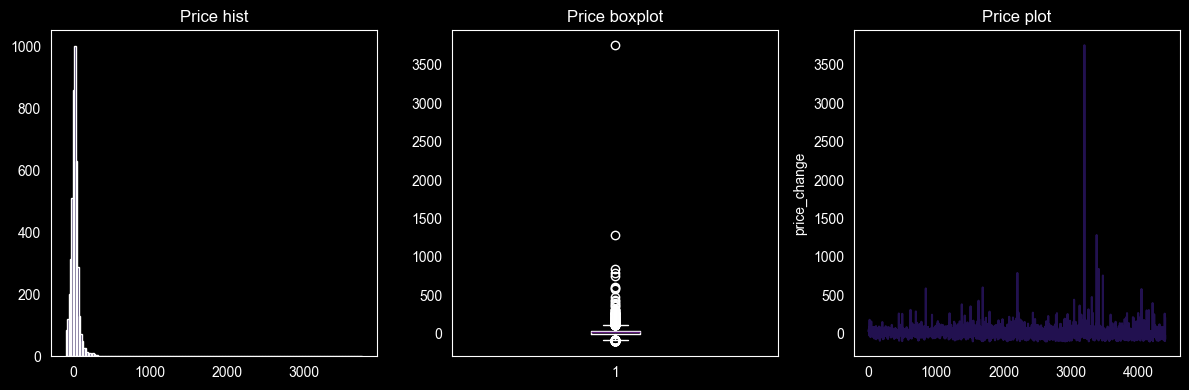

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].hist(data=df, x='price_change', bins=200)
ax[0].set_title('Price hist')
ax[1].boxplot(data=df, x='price_change')
ax[1].set_title('Price boxplot')
sns.lineplot(data=df, x=np.arange(df.shape[0]), y='price_change') 
ax[2].set_title('Price plot') 
plt.tight_layout()
plt.show() 

This data is very noisy, so it`s can be advisable to cut it in the range of 5 and 95 percentile:

The shape of price-normalised dataset (3952, 225)


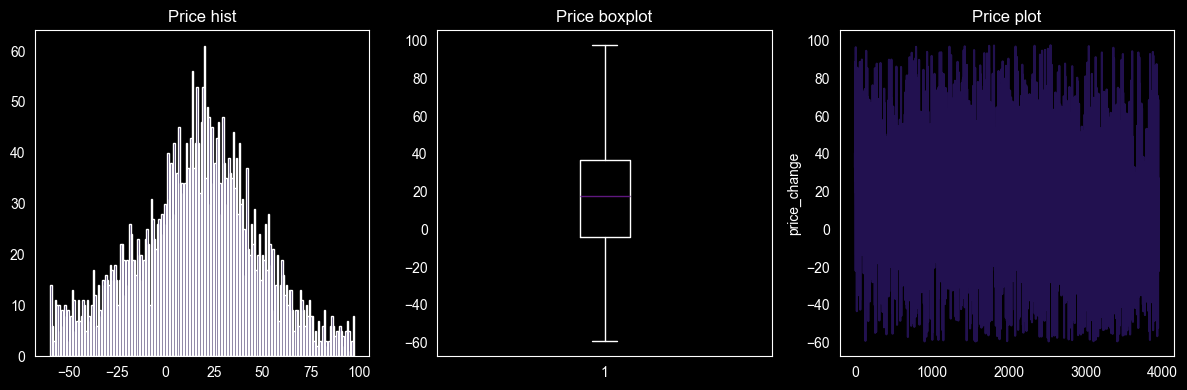

In [7]:
df_n = df[(df['price_change'] < df['price_change'].quantile(0.95)) &
          (df['price_change'] > df['price_change'].quantile(0.05))] 

print(f'The shape of price-normalised dataset {df_n.shape}') 
fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].hist(data=df_n, x='price_change', bins=200)
ax[0].set_title('Price hist')
ax[1].boxplot(data=df_n, x='price_change')
ax[1].set_title('Price boxplot')
sns.lineplot(data=df_n, x=np.arange(df_n.shape[0]), y='price_change') 
ax[2].set_title('Price plot') 
plt.tight_layout()
plt.show() 

Looks really better, now distribution of shares is visually closer to normal distribution.

The next important step is processing of missing values.

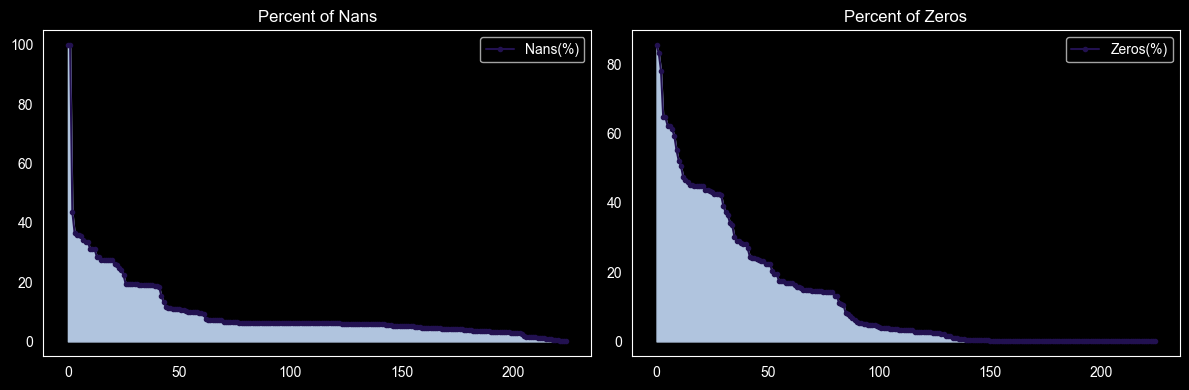

In [8]:
# looking for None and 0 values 
nans = pd.DataFrame(
    (df_n.isna().sum() / df_n.isna().count() * 100).sort_values(ascending=False)
    )
zeros = pd.DataFrame(
    (df_n.isin([0]).sum() / df_n.isin([0]).count() * 100).sort_values(ascending=False)
    ) 

fig, ax = plt.subplots(1, 2, figsize=(12, 4)) 
ax[0].plot(np.arange(len(nans)), nans[0], marker='.', label='Nans(%)') 
ax[0].set_title('Percent of Nans')
ax[0].fill_between(np.arange(len(nans)), nans[0], color='lightsteelblue')
ax[0].legend()
ax[1].plot(np.arange(len(zeros)), zeros[0], marker='.', label='Zeros(%)') 
ax[1].set_title('Percent of Zeros') 
ax[1].fill_between(np.arange(len(zeros)), zeros[0], color='lightsteelblue') 
ax[1].legend()
plt.tight_layout() 
plt.show() 

The chart shows that in some categories the percentage of missing or zero values ​​reaches 100%

43 - columns left


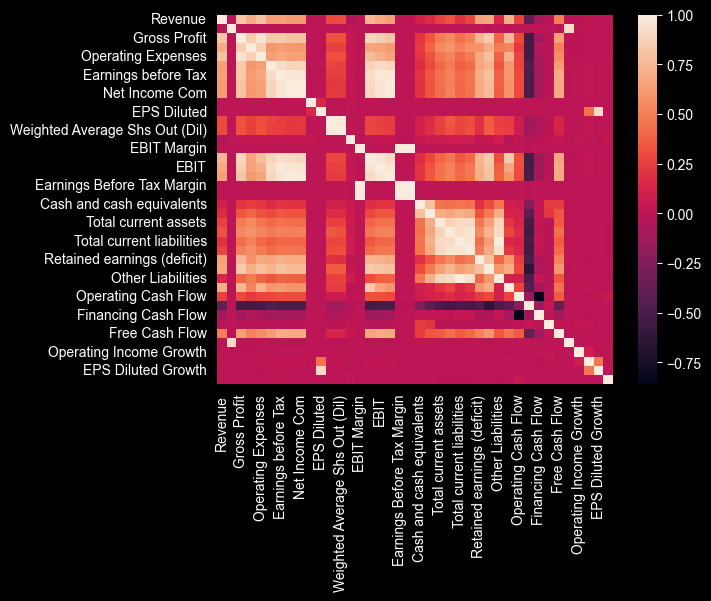

In [9]:
# drop columns where percantage more than 5%
nans_to_drop = nans[nans[0] > 5]
zeros_to_drop = zeros[zeros[0] > 5] 

df_n_0 = df_n.drop(columns=nans_to_drop.T.columns, inplace=False)
df_n_1 = df_n_0.drop(columns=[
    col for col in zeros_to_drop.T.columns if col in df_n_0],
    inplace=False) 

print(f'{df_n_1.shape[1]} - columns left') 

# we often fill missing values by averages 
# in this case I fill it by averages in sector 
df_n_1 = df_n_1.drop(columns=['ticker']) 
df_n_1 = df_n_1.groupby(['sector']).transform(lambda x: x.fillna(x.mean())) 

# just separating features by types
features = df_n_1.select_dtypes(include=['float64'])
features.drop(columns=['price_change'], inplace=True) 
sectors = df_n_0['sector'] 
target_values = df_n_0['class'] 

# and show the correlation matrix 
corr_matrix = features.corr() 
sns.heatmap(corr_matrix, annot=False)
plt.show() 

There are still low correlated features in data. ANOVA test can be usefull in this case to find ones that have a high correlation with target value. 

28 - columns left


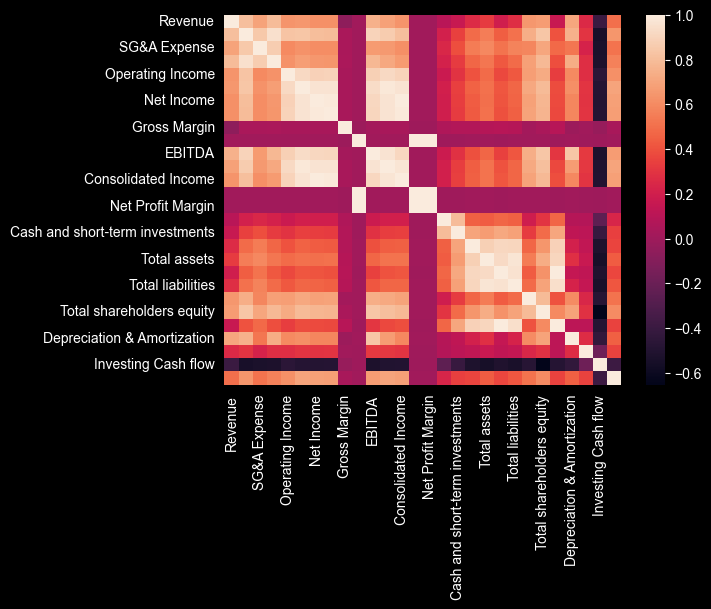

In [10]:
f_values, p_values = f_classif(features, df_n['class']) 

feature_values = pd.DataFrame({
    'feature': features.columns,
    'f_value': f_values,
    'p_value': p_values
}) 
# drop if P value more than 0.05 
features_filtred = feature_values[feature_values['p_value'] < 0.05]['feature'] 
features_n = features[features_filtred.values] 

print(f'{features_n.shape[1]} - columns left')
sns.heatmap(features_n.corr(), annot=False)
plt.show()

In next step I`ll analyse distribution of features that left.

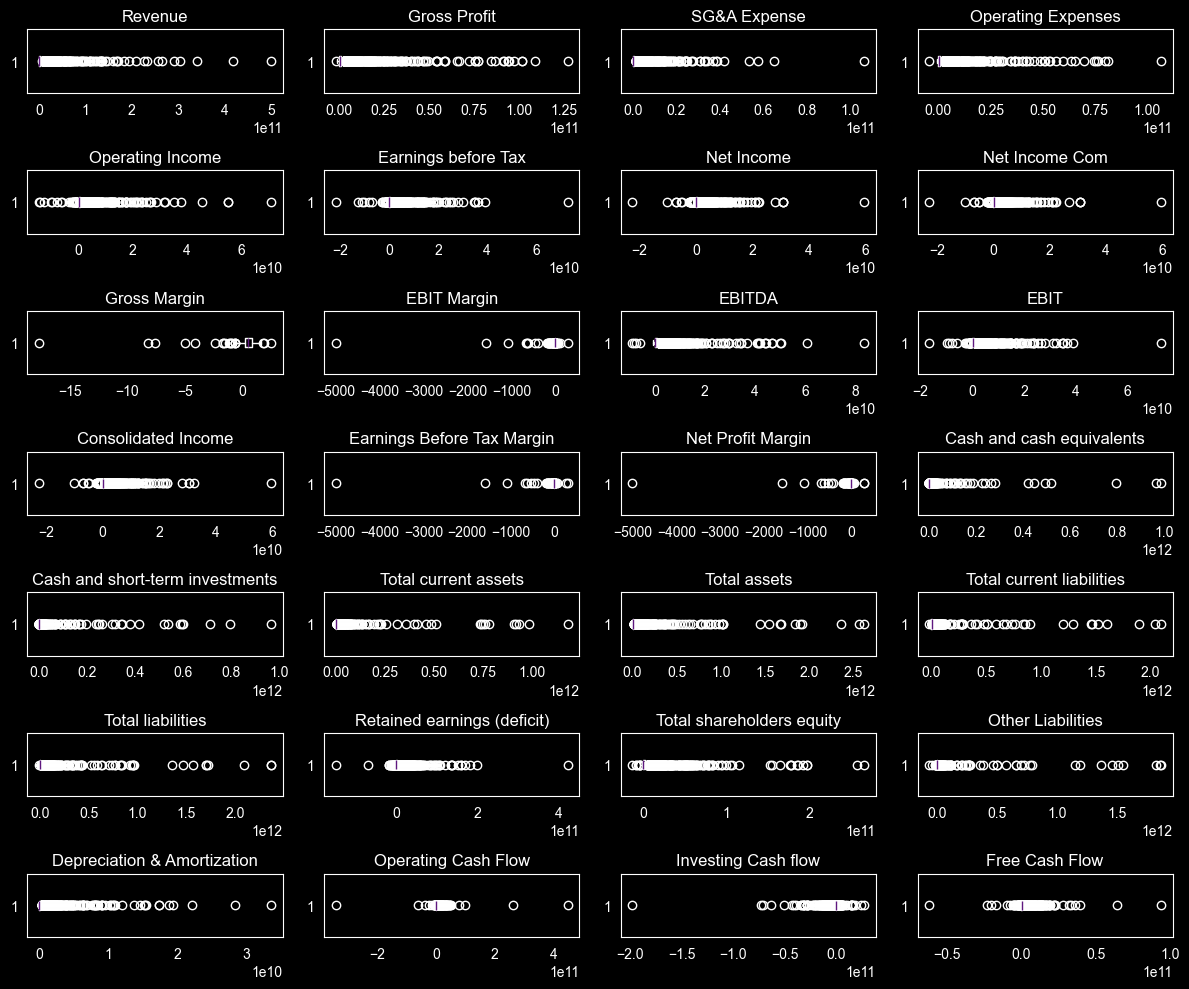

In [11]:
fig, axs = plt.subplots(7, 4, figsize=(12, 10))
ax = axs.ravel() 
for i, j in enumerate(features_n):
    ax[i].boxplot(features_n[j], vert=False)
    ax[i].set_title(j) 
plt.tight_layout()
plt.show() 

The distribution of feature values is highly noisy. This is due to the fact that we are dealing with companies of different sizes and with features that have varying units and measurement scales:

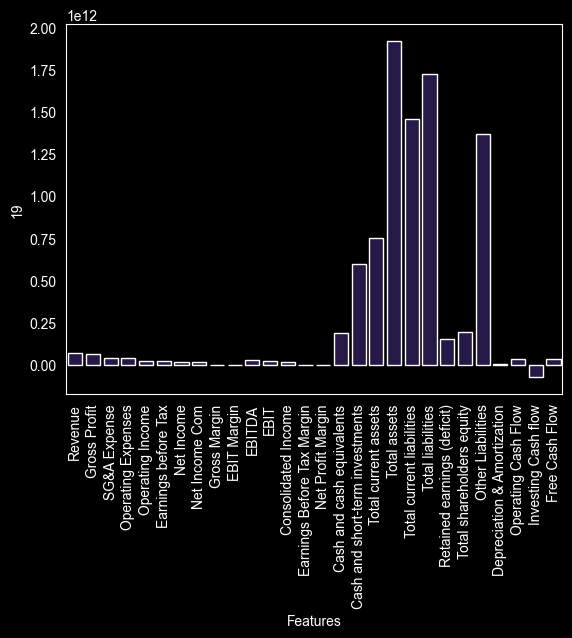

In [11]:
sns.barplot(x=features_n.columns, y=features_n.iloc[17])
plt.xticks(rotation=90) 
plt.xlabel('Features')
plt.show() 

To smooth out the differences in scale while preserving proportions, I will apply logarithmic transformation.

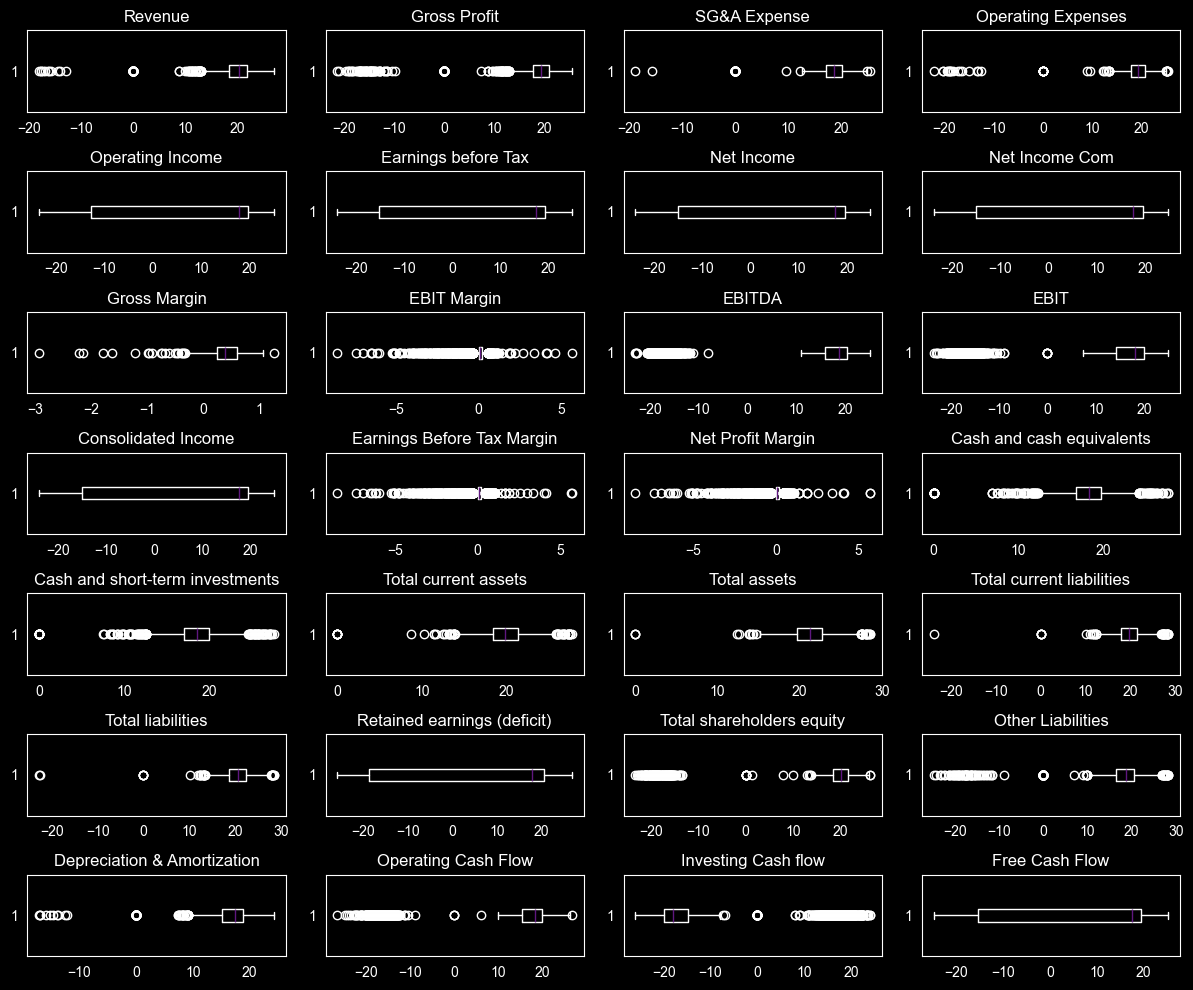

In [12]:
features_logs = features_n.apply(
    lambda x: np.sign(x) * np.log(np.abs(x) + 1)
) 

fig, axs = plt.subplots(7, 4, figsize=(12, 10))
ax = axs.ravel() 
for i, j in enumerate(features_logs):
    ax[i].boxplot(features_logs[j], vert=False)
    ax[i].set_title(j) 
plt.tight_layout()
plt.show() 

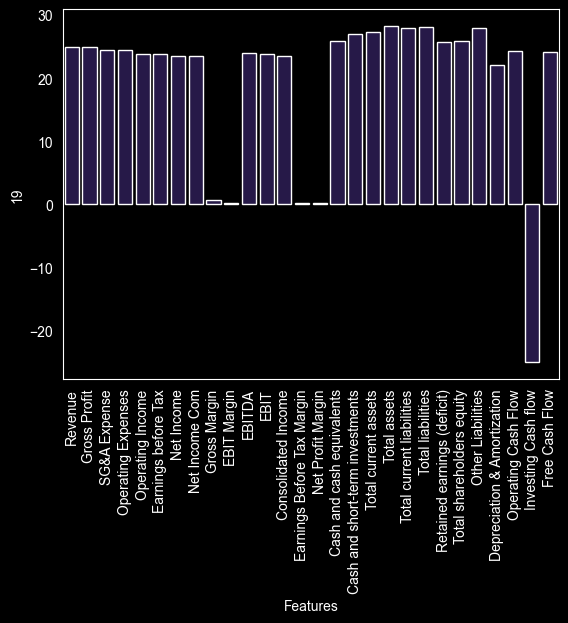

In [13]:
sns.barplot(x=features_logs.columns, y=features_logs.iloc[17])
plt.xticks(rotation=90)
plt.xlabel('Features') 
plt.show() 

Assessment of class balance.

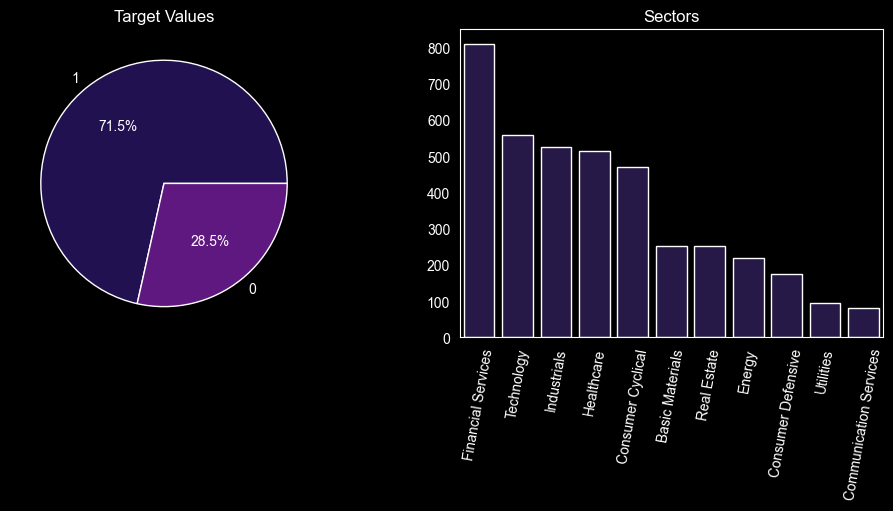

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].pie(df_n['class'].value_counts().values, labels=[1, 0], autopct='%1.1f%%')  
ax[0].set_title('Target Values')
sns.barplot(
    x=df_n['sector'].value_counts().index.to_list(), 
    y=df_n['sector'].value_counts().values 
) 
ax[1].set_title('Sectors')
plt.xticks(rotation=80)
plt.show() 

The classes are significantly imbalanced both in the target variable and across sectors. Reducing the number of examples in the more represented classes would lead to a considerable loss of information in both cases. To find the optimal way to address this issue, I will attempt to train models on different datasets: 1) with the original class proportions, 2) artificially balanced using the imblearn module and the SMOTE method.

In [15]:
# create final dataframe
df_prepared = pd.concat(
    [
        features_logs,
        pd.get_dummies(sectors),
        target_values
    ],
    axis=1
)
df_prepared.head() 

,Revenue,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Net Income,Net Income Com,Gross Margin,EBIT Margin,...,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities,class
0,25.271940,25.271940,24.894911,25.047372,23.668178,23.438689,23.185501,23.185501,0.693147,0.180153,...,True,False,False,False,False,False,False,False,False,1
1,23.372556,22.648390,20.214105,21.842334,22.056687,21.509903,21.198879,21.115983,0.395213,0.255262,...,False,False,True,False,False,False,False,False,False,1
2,24.983803,24.501460,22.632808,23.739830,23.872406,23.872449,23.770309,23.770309,0.480758,0.283147,...,False,False,False,False,False,False,False,True,False,1
3,24.137412,23.607564,20.516242,21.786942,23.430916,23.383735,23.371920,23.371920,0.462916,0.393325,...,False,False,False,False,False,False,False,True,False,1
4,25.524126,23.987268,23.619785,24.429764,-23.401338,-23.803891,-23.830316,-23.850114,0.194826,-0.128745,...,False,False,False,False,False,True,False,False,False,1


# Machine Learning

In [99]:
# split the data
X = df_prepared.select_dtypes(exclude=['int64']) 
Y = df_prepared['class'] 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=17) 

# create and split the artificially balanced data 
smote = SMOTE(random_state=17) 

X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train) 

# list of models to train 
models = [
    XGBClassifier(),
    LogisticRegression(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
    LGBMClassifier(verbose=-1), # set verbose=-1 to hide logs 
]

# and params grids for models 
params = {
    'LogisticRegression': {
        'penalty' :['l1', 'l2', 'elasticnet'],
        'C': [0.01, 0.1, 1],
        'max_iter': [50, 100, 150]
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 8, 10],
        'p': [1, 2] 
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4], 
    },
    'XGBClassifier': {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'gamma': [0, 0.1, 0.5],
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [1, 1.5, 2], 
        'scale_pos_weight': [1, 2, 5]
    },
    'LGBMClassifier': {
        'n_estimators': [50, 100, 150],
        'num_leaves': [31, 50, 100],
        'max_depth': [-1, 10, 20],
        'reg_alpha': [0, 0.1, 0.5, 1],
        'reg_lambda': [1, 1.5, 2],
    }
}

#####################
# necessary functions:

def try_model_(estims, x1, x2, y1, y2, metric):
    '''
    Evaluates multiple models and returns a DataFrame with their performance metrics.
    
    Fits each model on training data (`x1`, `y1`), predicts on test data (`x2`), 
    and calculates the train score, accuracy, and F1 score. The results are sorted 
    by the specified metric ('acc' for accuracy or 'f1' for F1 score).
    '''

    names, train_scores, accuracy_scores, f1_scores, predictions = [], [], [], [], []

    for estim in estims:

        model = estim 
        model.fit(x1, y1)
        ypr = model.predict(x2)

        name = str(estim).split('(')[0] 
        ts = model.score(x1, y1)
        acc = accuracy_score(y2, ypr) 
        f1 = f1_score(y2, ypr) 

        names.append(name)
        train_scores.append(ts)
        accuracy_scores.append(acc)
        f1_scores.append(f1) 
        predictions.append(ypr) 

    grades = pd.DataFrame({
        'estimator': names,
        'train_score': train_scores,
        'accuracy': accuracy_scores,
        'f1_score': f1_scores, 
        'prediction': predictions 
    })

    if metric == 'acc':
        return grades.sort_values(by=['accuracy'], ascending=False) 
    elif metric == 'f1':
        return grades.sort_values(by=['f1_score'], ascending=False)
    else:
        raise ValueError("Parameter 'metric' must be 'acc' or 'f1' to set score that dataframe sorted by") 
    

def decompositor(n, data):
    '''
    Reduces the dimensionality of the input data for visualization.
    
    This function applies Principal Component Analysis (PCA) to reduce the number of dimensions
    of the input data and returns a DataFrame with the reduced data.
    ''' 

    pca_ = PCA(n_components=n)
    pca_.fit(data) 
    data_ = pca_.transform(data)

    return pd.DataFrame(data_)  


def random_search_and_cross_validation_(estims, params, x, y, cv):
    '''
    Performs random search with cross-validation to find the best hyperparameters for multiple models.
    
    This function takes a list of estimators and a dictionary of hyperparameters, applies 
    RandomizedSearchCV with either StratifiedKFold ('skf') or KFold ('kf') cross-validation, 
    and returns a DataFrame with the best hyperparameters and scores for each model.
    '''

    names, params_, scores = [], [], [] 

    for estim in estims:
        for model_params in list(params.keys()):

            name = str(estim).split('(')[0] 
            params_grid = params[name] 

            if name == model_params:

                if cv == 'skf': # StratifiedKFold for balanced data 
                    searcher = RandomizedSearchCV(
                        estimator=estim,
                        param_distributions=params_grid,
                        n_iter=50,
                        cv=StratifiedKFold(n_splits=5),
                        random_state=17,
                        n_jobs=-1
                    )  
                elif cv == 'kf': # KFold for original class proportions 
                    searcher = RandomizedSearchCV(
                        estimator=estim,
                        param_distributions=params_grid, 
                        n_iter=50,
                        cv=KFold(n_splits=5), 
                        random_state=17,
                        n_jobs=-1
                    )
                else:
                    raise ValueError("Parameter cv must be 'skf' (for StratifiedKFold) or 'kf' (for KFold).") 
                
                searcher.fit(x,y) 

                best_params, best_score = searcher.best_params_, searcher.best_score_ 

                names.append(name)
                params_.append(best_params)
                scores.append(best_score) 

    result_df = pd.DataFrame({'Name': names, 'Parametres': params_, 'Score': scores}) 
    result_df = result_df.sort_values(by=['Score'], ascending=False) 

    return result_df 


Searching parametres and scores of the models.

With original data: 

In [102]:
result_0 = random_search_and_cross_validation_(estims=models, params=params, x=X_train, y=Y_train, cv='kf')
result_0.head() 

,Name,Parametres,Score
4,LGBMClassifier,"{'reg_lambda': 2, 'reg_alpha': 1, 'num_leaves'...",0.736475
3,RandomForestClassifier,"{'n_estimators': 50, 'min_samples_split': 5, '...",0.735525
0,XGBClassifier,"{'scale_pos_weight': 1, 'reg_lambda': 1.5, 're...",0.735209
1,LogisticRegression,"{'penalty': 'l2', 'max_iter': 150, 'C': 0.1}",0.730462
2,KNeighborsClassifier,"{'p': 1, 'n_neighbors': 5}",0.703575


And with resampled data:

In [103]:
result_1 = random_search_and_cross_validation_(estims=models, params=params, x=X_train, y=Y_train, cv='skf')
result_1.head()

,Name,Parametres,Score
4,LGBMClassifier,"{'reg_lambda': 1.5, 'reg_alpha': 1, 'num_leave...",0.739004
3,RandomForestClassifier,"{'n_estimators': 150, 'min_samples_split': 5, ...",0.738689
0,XGBClassifier,"{'scale_pos_weight': 5, 'reg_lambda': 1.5, 're...",0.735839
1,LogisticRegression,"{'penalty': 'l2', 'max_iter': 150, 'C': 1}",0.731096
2,KNeighborsClassifier,"{'p': 2, 'n_neighbors': 5}",0.705796


I select the three best estimators in both cases and look for their metrics to find the most accurate ones.

In [104]:
models_with_params_for_orginal_data = [
    RandomForestClassifier(**result_0['Parametres'].iloc[1]),
    LGBMClassifier(**result_0['Parametres'].iloc[0]),
    XGBClassifier(**result_0['Parametres'].iloc[2]) 
]
models_with_params_for_resampled_data = [
    RandomForestClassifier(**result_1['Parametres'].iloc[1]),
    LGBMClassifier(**result_1['Parametres'].iloc[0]),
    XGBClassifier(**result_1['Parametres'].iloc[2]) 
]

I will use the F1 metric to evaluate models trained on imbalanced data to assess how well they generalize the results. For models trained on balanced data, I will use the accuracy metric to evaluate the overall classification performance.

In [105]:
result_2 = try_model_(estims=models_with_params_for_orginal_data, x1=X_train, x2=X_test, y1=Y_train, y2=Y_test, metric='f1')  
result_2.iloc[:,0:-1] 

,estimator,train_score,accuracy,f1_score
0,RandomForestClassifier,0.984499,0.730721,0.826970
1,LGBMClassifier,0.893388,0.714286,0.811667
2,XGBClassifier,0.926922,0.690265,0.798021


In [106]:
result_3 = try_model_(
    estims=models_with_params_for_resampled_data, x1=X_train_resampled, x2=X_test, y1=Y_train_resampled, y2=Y_test, metric='acc'
)  
result_3.iloc[:,0:-1] 

,estimator,train_score,accuracy,f1_score
2,XGBClassifier,0.961062,0.697851,0.806791
1,LGBMClassifier,0.884956,0.687737,0.775250
0,RandomForestClassifier,0.971018,0.681416,0.767528


The models are actually overfitted. However, for a more comprehensive view, I would like to look at the confusion matrix of the results.

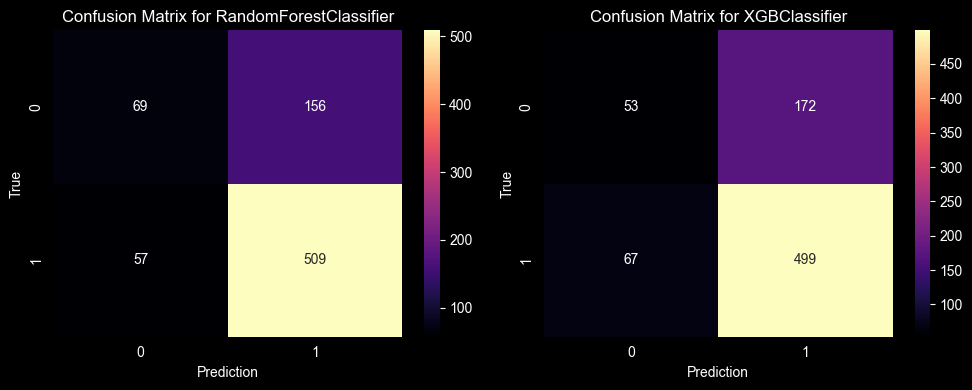

In [107]:
pred_NB = result_2['prediction'].iloc[0]
pred_B = result_3['prediction'].iloc[0] 

confusion_matrix_0 = confusion_matrix(Y_test, pred_NB) 
confusion_matrix_1 = confusion_matrix(Y_test, pred_B) 
confusions = [confusion_matrix_0, confusion_matrix_1] 
titles = [result_2['estimator'].iloc[0], result_3['estimator'].iloc[0]] 

fig, ax = plt.subplots(1, 2, figsize=(10,4))
for i, matrix in enumerate(confusions):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='magma', ax=ax[i])
    ax[i].set_xlabel('Prediction')
    ax[i].set_ylabel('True')
    ax[i].set_title(f'Confusion Matrix for {titles[i]}') 
plt.tight_layout()
plt.show() 

The first model more often interprets the negative class as positive, while the second model more frequently interprets the positive class as negative. Here, it’s essential to consider the nature of the task: it is better to miss out on buying a good company mistakenly evaluated as bad than to buy a bad one mistakenly assessed as good. In this context, I will choose the LGBMClassifier model.

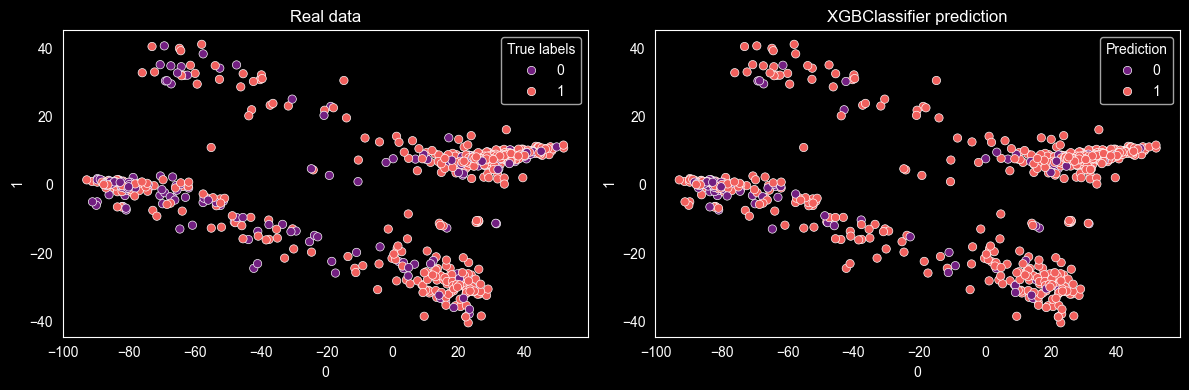

In [108]:
X_test_decomposed = decompositor(2, X_test) 
X_test_decomposed_df = X_test_decomposed 
X_test_decomposed_df["True labels"] = Y_test.reset_index(drop=True)
X_test_decomposed_df["Prediction"] = pd.DataFrame(pred_B).reset_index(drop=True)

hues = X_test_decomposed_df[['True labels', 'Prediction']]
titles_ = ['Real data', f"{result_3['estimator'].iloc[0]} prediction"] 

fig, ax = plt.subplots(1, 2, figsize=(12,4))
for i, h in enumerate(hues):
    sns.scatterplot(data=X_test_decomposed, x=0, y=1, hue=h, palette='magma', ax=ax[i], alpha=1) 
    ax[i].set_title(f'{titles_[i]}') 
plt.tight_layout()
plt.show() 


Now I will make predictions on random data and compare them with the actual stock charts for the following (2019) year after the forecast (2018).

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


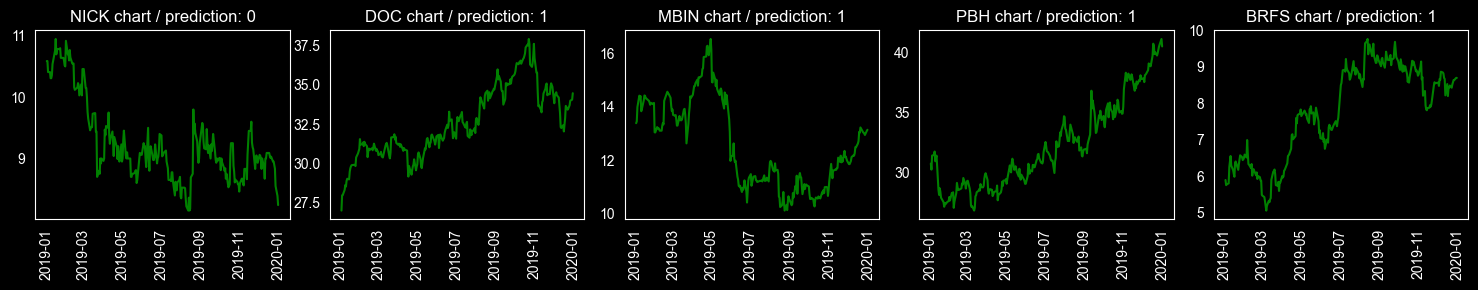

In [133]:
r = np.random.randint(0, len(df_prepared) + 1, 5) # take 5 companies for example 

tickers = [df_n.iloc[j,0] for j in r] 
features__ = [X.iloc[m,:] for m in r]

predictions = models_with_params_for_resampled_data[1].predict(features__) 

market_data = []
for ticker in tickers:
    chart = yf.download(ticker, start="2019-01-01", end="2020-01-01")
    market_data.append(chart) 

fig, ax = plt.subplots(1, 5, figsize=(15,3)) 
for n, stock in enumerate(market_data):
    ax[n].plot(stock['Close'], color='green') 
    ax[n].set_title(f'{tickers[n]} chart / prediction: {predictions[n]}')
    ax[n].tick_params(axis='x', labelrotation = 90) 
plt.tight_layout()
plt.show() 